#### python中所有集合都可以迭代，Python内部迭代器用于支持：  
for循环  
构建和扩展集合  
逐行遍历文件  
列表推导、字典推导和集合推导  
元组拆包  
函数调用时*用于实参拆包
# python自动调用iter()进行迭代
当解释器需要迭代对象时会自动调用iter函数。iter()函数有以下行为：  
1.当对象实现了\__iter__方法则直接调用获取迭代器对象。  
2.否则检查是否实现\__getitem__，若有则python会创建迭代器对象并从__索引0__开始调用该方法获取元素。  
3.1、2失败则抛出TypeError。

python内置序列都实现了\__getitem__和\__iter__，\__getitem__可用于迭代的备用机制（便于向后兼容）。因此自己实现的序列应当实现两种方法，

对于标准的可迭代类型来说，只需实现获取对应迭代器对象的\__iter__函数（白鹅类型）
#### python的abc.Iterable类实现了对该方法检查的\__subclasshook__方法。

In [1]:
import re
import reprlib

RE_WORD = re.compile('\w+')


class Sentence:
    # 接受文本完成初始化
    def __init__(self, text):
        self.text = text
        self.words = RE_WORD.findall(text)
        
    def __getitem__(self, index):
        return self.words[index] # 索引委托给words实现
    
    def __len__(self):
        return len(self.words)
    
    def __repr__(self):
        return 'Sentence(%s)' % reprlib.repr(self.text) # reprlib.repr可输出大型数据的简略表示

# 可迭代对象与迭代器
## 可迭代对象
可迭代对象需要给出对应的迭代器对象，因此可迭代对象需要实现\__iter__方法暴露产生迭代器对象的接口（\__getitem__用于解释器为其创建默认迭代器对象）。__因此可迭代对象相当于数据存储器。__
## 迭代器
用于执行对可迭代对象的迭代逻辑，__相当于执行器__。迭代器需要实现\__next__方法，给出具体的下一个元素对象。同时__迭代器的状态是不可恢复的，当迭代完成想重新迭代时，必须创建新的迭代器。__

python中的迭代器还需要实现\__iter__方法用于返回自己，这种要求更多的是便于python语法层面的统一实现,即：迭代器的迭代器还是自己。

__类似Iterable，Iterator也实现了检查next和iter方法的subclasshook方法__

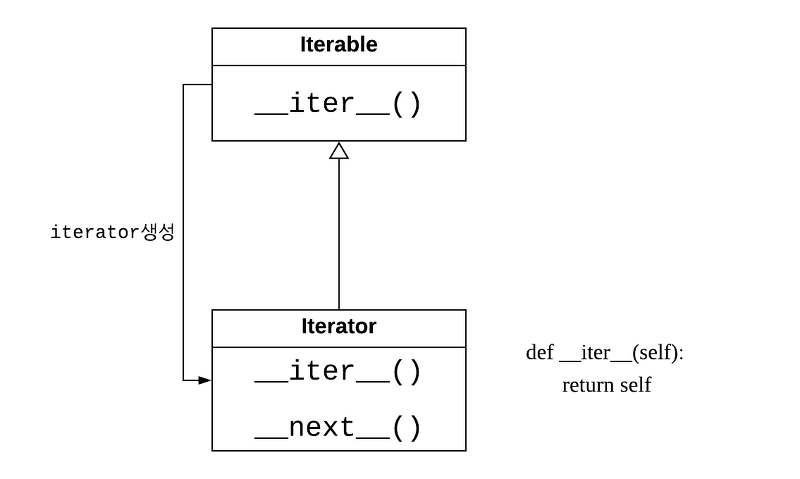
python在使用迭代器对象执行迭代逻辑时的实例（迭代完成会抛出StopIteration异常）：

In [3]:
s = 'ABC'
for char in s:
    print(char)
    
# 等价于
s = 'ABC'
it = iter(s)
while True:
    try:
        print(next(it))
    except StopIteration:
        del it
        break

A
B
C
A
B
C


# 典型的迭代器模式
SentenceIterator负责执行Sentence的迭代逻辑，切记不要试图在Sentence内实现\__next__方法以求作为迭代器迭代自己（可迭代对象不是迭代器），__这种做法违背了可迭代对象作为数据承载者而迭代器作为对其执行迭代逻辑的‘执行器’这种解耦思想__。这种解耦思想的另外优点是可以使得一个可迭代对象支持多种迭代逻辑，且每个迭代器对象拥有独立的内部状态，__因此可迭代对象实现的iter方法需要返回新的迭代器对象__。

In [4]:
import re
import reprlib

RE_WORD = re.compile('\w+')


class Sentence:
    # 接受文本完成初始化
    def __init__(self, text):
        self.text = text
        self.words = RE_WORD.findall(text)
    
    def __repr__(self):
        return 'Sentence(%s)' % reprlib.repr(self.text) # reprlib.repr可输出大型数据的简略表示
    
    # 实现协议，返回新迭代器对象。
    def __iter__(self):
        return SentenceIterator(self.words)
    
    
class SentenceIterator:
    '''
    迭代器，next中封装了对Sentence可迭代对象的迭代逻辑，且是一次性的。
    '''
    def __init__(self, words):
        self.index = 0
        self.words = words
        
    def __next__(self):
        try:
            word = self.words[self.index]
        except IndexError:
            raise StopIteration()
        self.index += 1
        return word
    
    def __iter__(self):
        return self

# 生成器函数
使用生成器函数作为迭代器代替上面SentenceIterator类，生成器函数执行后会返回一个生成器对象，__因此生成器函数是生成器生产工厂函数__。

生成器（generator）为内置类型，它实现了迭代器协议，同样其\__iter__方法返回自身。

In [1]:
import re
import reprlib

RE_WORD = re.compile('\w+')

class Sentence:
    def __init__(self, text):
        self.text = text
        self.words = RE_WORD.findall(text)
    
    def __repr__(self):
        return 'Sentence(%s)' % reprlib.repr(self.text) # reprlib.repr可输出大型数据的简略表示
    
    # 实现协议，返回新迭代器对象（生成器函数执行后返回一个新的生成器对象）。
    def __iter__(self):
        for word in self.words:
            yield word

In [4]:
def gen_123():
    yield 1
    yield 2
    yield 3
    
# 生成器函数返回的生成器对象本身就是迭代器。
gen_obj = gen_123()
print(next(gen_obj))
print(next(gen_obj))
print(next(gen_obj))
print(next(gen_obj))

1
2
3


StopIteration: 

#### 生成器不会像普通迭代器那样返回一个值，而是通过yield‘生产’一个值，在使用生成器时经常通过逻辑‘凭空’产生元素（如：斐波那契数列）而无需数据源，这种情况下的生成器函数生产的生成器对象即是承载数据的‘可迭代对象’，也是执行迭代逻辑的‘迭代器’，两者是紧耦合的。
# 惰性Sentence
之前版本的Sentence使用的findall返回列表，这样可能导致内存溢出。使用re.finditer函数会返回生成器对象，这样对其迭代便可‘按需生产元素’节省内存。

In [10]:
import re
import reprlib

RE_WORD = re.compile('\w+')

class Sentence:
    def __init__(self, text):
        self.text = text
    
    def __repr__(self):
        return 'Sentence(%s)' % reprlib.repr(self.text) # reprlib.repr可输出大型数据的简略表示
    
    # 实现协议，返回新生成器对象。该生成器函数实际上对已有生成器对象（迭代器）进行了包装，每次从RE_WORD.finditer(self.text)生成器中获取元素。
    def __iter__(self):
        # 这里每次都需要使用RE_WORD.finditer()获取新的生成器对象
        for match in RE_WORD.finditer(self.text):
            yield match.group()

## 生成器表达式
生成器表达式与生成器函数一样可以作为工厂函数生产生成器对象。因此上述\__iter__方法可进一步简化为生成器表达式，__这种形式目的更加直接，使用生成器表达式包装已有生成器对象以增强功能（这里是使用group()方法返回匹配字符串）__，获得生成器的生成器。

In [9]:
def __iter__(self):
    return (match.group() for match in RE_WORD.finditer(self.text))

# 标准库中的生成器函数
标准库中有很多好用的生成器函数，如os.walk返回的生成器,可以在遍历目录树的过程中产出文件名。这些生成器函数有些是内置的有些在itertools的functools模块中。
# yield from与使用iter创建迭代器
yield from可用于对任何可迭代对象包装为生成器形式，如：

In [11]:
def gen_1():
    for char in 'abc':
        yield char
    
# 与上例等价
def gen_2():
    yield from 'abc'
    
for i in gen_2():
    print(i)

a
b
c


iter()方法可用于创建迭代器对象，此时第一个参数为可调用对象，每次调用时返回一个值。第二个参数为哨符。